Modified from https://developers.google.com/machine-learning/crash-course/classification/programming-exercise

# Binary Classification

So far, you've only created regression models. That is, you created models that produced floating-point predictions, such as, "houses in this neighborhood costs N thousand dollars." In this Colab, you'll create and evaluate a binary [classification model](https://developers.google.com/machine-learning/glossary/#classification_model).  That is, you'll create a model that answers a binary question. In this exercise, the binary question will be, "Are houses in this neighborhood above a certain price?"





## Learning Objectives:

After doing this Colab, you'll know how to:

  * Convert a regression question into a classification question.
  * Modify the classification threshold and determine how that modification influences the model.
  * Experiment with different classification metrics to determine your model's effectiveness.

## The Dataset
  
Like several of the previous Colabs, this Colab uses the [California Housing Dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description).

## Call the import statements

The following code imports the necessary modules.

In [47]:
#title Load the imports

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
# tf.keras.backend.set_floatx('float32')

print("Ran the import statements.")

Ran the import statements.


## Load the datasets from the internet

The following code cell loads the separate .csv files and creates the following two pandas DataFrames:

* `train_df`, which contains the training set
* `test_df`, which contains the test set

In [48]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the training set

train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
2944,-117.8,33.8,19.0,3532.0,402.0,1200.0,426.0,11.0,500001.0
6066,-118.2,33.9,37.0,797.0,190.0,485.0,166.0,2.7,95200.0
4381,-118.0,33.8,34.0,3482.0,614.0,2227.0,641.0,5.1,200900.0
10507,-120.4,35.0,18.0,1932.0,350.0,1071.0,346.0,4.1,139800.0
12377,-121.5,38.3,47.0,1396.0,254.0,630.0,218.0,2.9,92500.0


## Create a binary label

In classification problems, the label for every example must be either 0 or 1. Unfortunately, the natural label in the California Housing Dataset, `median_house_value`, contains floating-point values like 80,100 or 85,700 rather than 0s and 1s, while the normalized version of `median_house_values` contains floating-point values primarily between -3 and +3.

Your task is to create a new column named `median_house_value_is_high` in both the training set and the test set . If the `median_house_value` is higher than a certain arbitrary value (defined by `threshold`), then set `median_house_value_is_high` to 1. Otherwise, set `median_house_value_is_high` to 0. 

**Hint:** The cells in the `median_house_value_is_high` column must each hold `1` and `0`, not `True` and `False`. To convert `True` and `False` to  `1` and `0`, call the pandas DataFrame function `astype(float)`. 

In [50]:
# We arbitrarily set the threshold to 265,000, which is 
# the 75th percentile for median house values.  Every neighborhood
# with a median house price above 265,000 will be labeled 1, 
# and all other neighborhoods will be labeled 0.
threshold = 265000

y_train = (train_df["median_house_value"] > threshold).astype(float)
y_test  = (test_df["median_house_value"]  > threshold).astype(float) 

print(y_train.head(20))

import statistics
print(statistics.mean(y_train))

# 0 is majority class


2944    1.0
6066    0.0
4381    0.0
10507   0.0
12377   0.0
         ..
3162    0.0
11148   0.0
14999   1.0
7599    0.0
8817    1.0
Name: median_house_value, Length: 20, dtype: float64
0.2498235294117647


##Create X_train, X_test

In [51]:
train_df.describe()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207300.9
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,115983.8
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119400.0
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180400.0
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265000.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500001.0


In [52]:
X_train = pd.concat( [train_df["median_income" ], train_df["total_rooms" ]], axis = 1)

X_test  = pd.concat( [test_df["median_income" ],  test_df["total_rooms" ]],  axis = 1)

# X_train.describe()
X_test.describe()

,median_income,total_rooms
count,3000.0,3000.0
mean,3.8,2599.6
std,1.9,2155.6
min,0.5,6.0
25%,2.5,1401.0
50%,3.5,2106.0
75%,4.7,3129.0
max,15.0,30450.0


##Common formatting options

In [53]:
# ------ Common formating options ---------
plt.style.use('seaborn-whitegrid')

SMALL_SIZE = 20
MEDIUM_SIZE = 30
BIGGER_SIZE = 40

plt.rc('font', size=SMALL_SIZE)           # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)      # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

plt.rcParams["figure.figsize"] = (15,10)
# ------ end format ---------



## Logistic regression

Optimization terminated successfully.
         Current function value: 0.629149
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:     median_house_value   No. Observations:                17000
Model:                          Logit   Df Residuals:                    16998
Method:                           MLE   Df Model:                            1
Date:                Fri, 24 Sep 2021   Pseudo R-squ.:                 -0.1192
Time:                        23:07:28   Log-Likelihood:                -10696.
converged:                       True   LL-Null:                       -9556.4
Covariance Type:            nonrobust   LLR p-value:                     1.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
median_income     0.0626      0.007      9.521      0.000       0.050       0.076
total_rooms      -0.

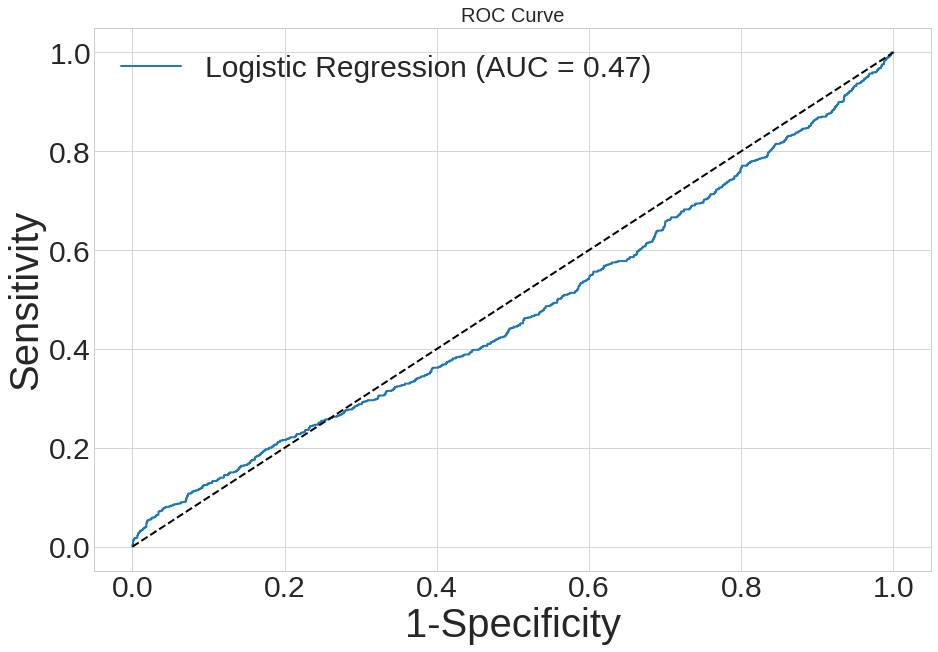

              precision    recall  f1-score   support

         0.0     0.7574    0.9445    0.8407      2254
         1.0     0.3386    0.0858    0.1369       746

    accuracy                         0.7310      3000
   macro avg     0.5480    0.5152    0.4888      3000
weighted avg     0.6533    0.7310    0.6657      3000



In [54]:
import statsmodels.api as sm

model_1=sm.Logit(y_train, X_train).fit()
print(model_1.summary())
print('---')
print(model_1.summary2())


print('---')

#  Train set:  Confusion Matrix

cm = model_1.pred_table() # this gives confusion matrix
print(cm)  


# metrics on test dataset ---------

#predictions 
predictions=model_1.predict(X_test)
print(predictions)

# AUC & ROC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, t = roc_curve(      y_test, predictions)
logit_roc_auc = roc_auc_score(y_test, predictions)

# -------------
plt.plot(fpr, tpr,  
         linewidth = 2, 
         label='Logistic Regression (AUC = %0.2f)' % logit_roc_auc)

plt.plot([0,1],[0,1], 'k--', linewidth = 2)
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC Curve')
plt.legend()
plt.show();

# classification report needs binary values
from sklearn.metrics import classification_report
predictions = np.round(predictions) # classification_report needs a binary input
report = classification_report(y_test, predictions, digits=4)
print(report)

## "All-in-one" neural network with normalization and metrics

Number of features is 2
 
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


136/136 [==============================] - 1s 3ms/step - loss: 0.5319 - accuracy: 0.7505 - val_loss: 0.4477 - val_accuracy: 0.7726
Epoch 2/20
136/136 [==============================] - 0s 2ms/step - loss: 0.4347 - accuracy: 0.8114 - val_loss: 0.4046 - val_accuracy: 0.8312
Epoch 3/20
136/136 [==============================] - 0s 2ms/step - loss: 0.4110 - accuracy: 0.8235 - val_loss: 0.3932 - val_accuracy: 0.8312
Epoch 4/20
136/136 [==============================] - 0s 2ms/step - loss: 0.4033 - accuracy: 0.8269 - val_loss: 0.3887 - val_accuracy: 0.8341
Epoch 5/20
136/136 [==============================] - 0s 2ms/step - loss: 0.4005 - accuracy: 0.8285 - val_loss: 0.3875 - val_accuracy: 0.8356
Epoch 6/20
136/136 [==============================] - 0s 2ms/step - loss: 0.3989 - accuracy: 0.8290 - val_loss: 0.3854 - val_accuracy: 0.8371
Epoch 7/20
136/136 [==============================] - 0s 2ms/step - loss: 0.3979 - accuracy: 0.8308 - val_loss: 0.3854 - val_accuracy: 0.8382
Epoch 8/20
136/13

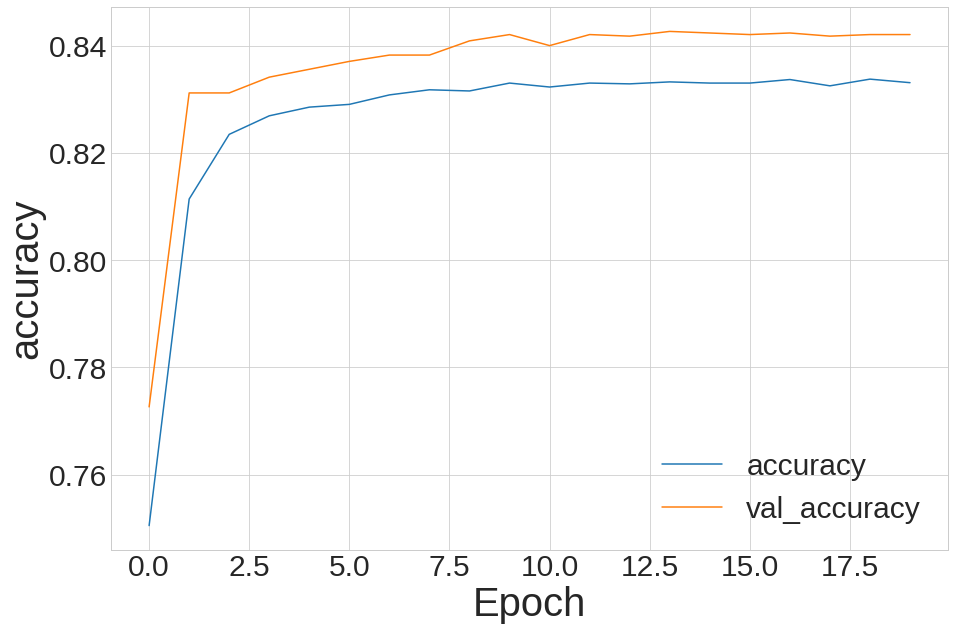

AUC = 0.8285324154140034
              precision    recall  f1-score   support

         0.0     0.8374    0.9618    0.8953      2254
         1.0     0.7908    0.4357    0.5618       746

    accuracy                         0.8310      3000
   macro avg     0.8141    0.6988    0.7286      3000
weighted avg     0.8258    0.8310    0.8124      3000



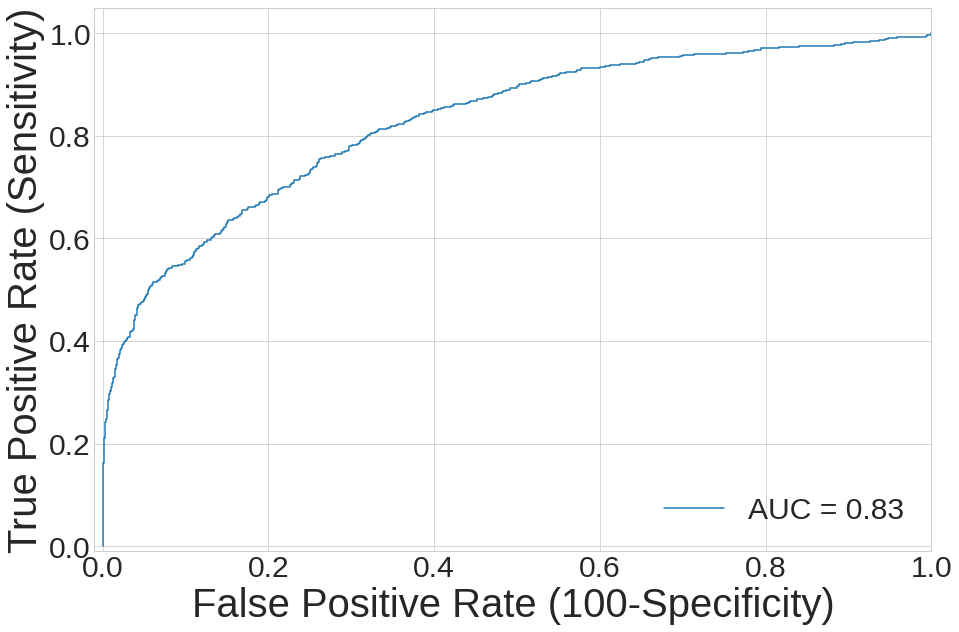

In [55]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers.experimental import preprocessing


# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.5   


# Establish the metrics the model will measure.
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
          ]

# Normalizer
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)

# Create Neural Network
number_of_inputs= X_train.shape[1]
print(f"Number of features is {number_of_inputs}")
print(" ")
model = keras.Sequential([normalizer,
                          layers.Dense(10, activation='relu', input_dim=number_of_inputs),
                          layers.Dense(10, activation='relu'),
                          layers.Dense(1, activation='sigmoid') ]) # output layer for regression


#Compile   
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate),                                                   
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

history = model.fit(x=X_train, 
                    y=y_train, 
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split = 0.2)  # Calculate validation results on 20% of the training data)

# Extract training history
epochs = history.epoch
hist = pd.DataFrame(history.history)

# plot curve
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')

# plt.ylim([1,y_lim])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)
plt.show()


# -------------- Metrics on holdout set

# prepare features
my_holdout = X_test
my_holdout_label = y_test

# predict using model
y_pred = model.predict(my_holdout)


# AUC

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr, tpr, thresholds = roc_curve(my_holdout_label, y_pred)
AUC_from_fn = auc(fpr, tpr)
print(f"AUC = {AUC_from_fn}")

# ROC curve
fpr, tpr, thresholds = roc_curve(my_holdout_label, y_pred)
plt.plot(fpr, tpr, label='AUC = %0.2f' % AUC_from_fn)
plt.xlabel('False Positive Rate (100-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.legend(loc="lower right")

# accuracy, precision, recall, F1 from classification_report
from sklearn.metrics import classification_report
y_pred = np.round(y_pred) # classification_report needs a binary input
report = classification_report(my_holdout_label, y_pred, digits=4)
print(report)

## compare to trivial model
## be sure to tune model


## Hyperparameter sweep: classification threshold

Experiment with different values for `classification_threshold` in the code cell within "Invoke the creating, training, and plotting functions."  What value of `classification_threshold` produces the highest accuracy?

Number of features is 2
 
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


136/136 [==============================] - 2s 5ms/step - loss: 0.5599 - accuracy: 0.2510 - precision: 0.2510 - recall: 1.0000 - val_loss: 0.4546 - val_accuracy: 0.2456 - val_precision: 0.2451 - val_recall: 1.0000
Epoch 2/10
136/136 [==============================] - 0s 2ms/step - loss: 0.4207 - accuracy: 0.3782 - precision: 0.2842 - recall: 0.9725 - val_loss: 0.3891 - val_accuracy: 0.5406 - val_precision: 0.3395 - val_recall: 0.9256
Epoch 3/10
136/136 [==============================] - 0s 2ms/step - loss: 0.4010 - accuracy: 0.5558 - precision: 0.3528 - recall: 0.9224 - val_loss: 0.3860 - val_accuracy: 0.5574 - val_precision: 0.3484 - val_recall: 0.9268
Epoch 4/10
136/136 [==============================] - 0s 2ms/step - loss: 0.3987 - accuracy: 0.5640 - precision: 0.3575 - recall: 0.9238 - val_loss: 0.3850 - val_accuracy: 0.5594 - val_precision: 0.3498 - val_recall: 0.9292
Epoch 5/10
136/136 [==============================] - 0s 2ms/step - loss: 0.3976 - accuracy: 0.5621 - precision: 0.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


136/136 [==============================] - 2s 5ms/step - loss: 0.4925 - accuracy: 0.4362 - precision: 0.3030 - recall: 0.9584 - val_loss: 0.4137 - val_accuracy: 0.6115 - val_precision: 0.3773 - val_recall: 0.9004
Epoch 2/10
136/136 [==============================] - 0s 2ms/step - loss: 0.4096 - accuracy: 0.6724 - precision: 0.4233 - recall: 0.8421 - val_loss: 0.3895 - val_accuracy: 0.7221 - val_precision: 0.4616 - val_recall: 0.8091
Epoch 3/10
136/136 [==============================] - 0s 2ms/step - loss: 0.4012 - accuracy: 0.7149 - precision: 0.4608 - recall: 0.7996 - val_loss: 0.3863 - val_accuracy: 0.7468 - val_precision: 0.4896 - val_recall: 0.7887
Epoch 4/10
136/136 [==============================] - 0s 2ms/step - loss: 0.3988 - accuracy: 0.7229 - precision: 0.4691 - recall: 0.7879 - val_loss: 0.3861 - val_accuracy: 0.7503 - val_precision: 0.4939 - val_recall: 0.7755
Epoch 5/10
136/136 [==============================] - 0s 2ms/step - loss: 0.3975 - accuracy: 0.7328 - precision: 0.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
136/136 [==============================] - 2s 5ms/step - loss: 0.5538 - accuracy: 0.5607 - precision: 0.3313 - recall: 0.7361 - val_loss: 0.4425 - val_accuracy: 0.7688 - val_precision: 0.5201 - val_recall: 0.7299
Epoch 2/10
136/136 [==============================] - 0s 2ms/step - loss: 0.4341 - accuracy: 0.7737 - precision: 0.5390 - recall: 0.6798 - val_loss: 0.4008 - val_accuracy: 0.7944 - val_precision: 0.5667 - val_recall: 0.6831
Epoch 3/10
136/136 [==============================] - 0s 2ms/step - loss: 0.4103 - accuracy: 0.7882 - precision: 0.5655 - recall: 0.6740 - val_loss: 0.3915 - val_accuracy: 0.7988 - val_precision: 0.5780 - val_recall: 0.6627
Epoch 4/10
136/136 [==============================] - 0s 2ms/step - loss: 0.4026 - accuracy: 0.7956 - precision: 0.5826 - recall: 0.6547 - val_loss: 0.3879 - val_accuracy: 0.7997 - val_precision: 0.5800 - val_recall: 0.6615
Epoch 5/10
136/136 [==============================] - 0s 2ms/step - loss: 0.3997 - accuracy: 0.7994 - pr

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


136/136 [==============================] - 2s 5ms/step - loss: 0.5713 - accuracy: 0.5393 - precision: 0.3378 - recall: 0.8699 - val_loss: 0.4573 - val_accuracy: 0.7976 - val_precision: 0.5744 - val_recall: 0.6723
Epoch 2/10
136/136 [==============================] - 0s 2ms/step - loss: 0.4217 - accuracy: 0.8101 - precision: 0.6253 - recall: 0.6081 - val_loss: 0.3897 - val_accuracy: 0.8268 - val_precision: 0.6704 - val_recall: 0.5762
Epoch 3/10
136/136 [==============================] - 0s 2ms/step - loss: 0.3998 - accuracy: 0.8195 - precision: 0.6640 - recall: 0.5685 - val_loss: 0.3873 - val_accuracy: 0.8232 - val_precision: 0.6563 - val_recall: 0.5846
Epoch 4/10
136/136 [==============================] - 0s 2ms/step - loss: 0.3983 - accuracy: 0.8207 - precision: 0.6683 - recall: 0.5671 - val_loss: 0.3855 - val_accuracy: 0.8294 - val_precision: 0.6815 - val_recall: 0.5702
Epoch 5/10
136/136 [==============================] - 0s 2ms/step - loss: 0.3975 - accuracy: 0.8232 - precision: 0.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


136/136 [==============================] - 2s 5ms/step - loss: 0.6199 - accuracy: 0.5451 - precision: 0.3359 - recall: 0.8316 - val_loss: 0.5235 - val_accuracy: 0.8188 - val_precision: 0.6460 - val_recall: 0.5762
Epoch 2/10
136/136 [==============================] - 0s 2ms/step - loss: 0.4554 - accuracy: 0.8258 - precision: 0.7006 - recall: 0.5346 - val_loss: 0.3970 - val_accuracy: 0.8379 - val_precision: 0.7366 - val_recall: 0.5270
Epoch 3/10
136/136 [==============================] - 0s 2ms/step - loss: 0.4039 - accuracy: 0.8296 - precision: 0.7210 - recall: 0.5237 - val_loss: 0.3896 - val_accuracy: 0.8382 - val_precision: 0.7331 - val_recall: 0.5342
Epoch 4/10
136/136 [==============================] - 0s 2ms/step - loss: 0.4008 - accuracy: 0.8292 - precision: 0.7188 - recall: 0.5249 - val_loss: 0.3879 - val_accuracy: 0.8371 - val_precision: 0.7211 - val_recall: 0.5462
Epoch 5/10
136/136 [==============================] - 0s 2ms/step - loss: 0.3993 - accuracy: 0.8293 - precision: 0.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


136/136 [==============================] - 2s 5ms/step - loss: 0.6202 - accuracy: 0.7174 - precision: 0.4440 - recall: 0.4985 - val_loss: 0.5086 - val_accuracy: 0.8329 - val_precision: 0.7183 - val_recall: 0.5234
Epoch 2/10
136/136 [==============================] - 0s 2ms/step - loss: 0.4526 - accuracy: 0.8296 - precision: 0.7456 - recall: 0.4877 - val_loss: 0.3983 - val_accuracy: 0.8394 - val_precision: 0.7633 - val_recall: 0.4994
Epoch 3/10
136/136 [==============================] - 0s 2ms/step - loss: 0.4019 - accuracy: 0.8309 - precision: 0.7598 - recall: 0.4772 - val_loss: 0.3873 - val_accuracy: 0.8385 - val_precision: 0.7407 - val_recall: 0.5246
Epoch 4/10
136/136 [==============================] - 0s 2ms/step - loss: 0.3984 - accuracy: 0.8310 - precision: 0.7499 - recall: 0.4900 - val_loss: 0.3863 - val_accuracy: 0.8391 - val_precision: 0.7483 - val_recall: 0.5174
Epoch 5/10
136/136 [==============================] - 0s 2ms/step - loss: 0.3976 - accuracy: 0.8321 - precision: 0.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


136/136 [==============================] - 2s 5ms/step - loss: 0.6175 - accuracy: 0.7775 - precision: 0.9145 - recall: 0.1254 - val_loss: 0.5213 - val_accuracy: 0.8247 - val_precision: 0.9129 - val_recall: 0.3145
Epoch 2/10
136/136 [==============================] - 0s 2ms/step - loss: 0.4558 - accuracy: 0.8254 - precision: 0.8453 - recall: 0.3729 - val_loss: 0.3975 - val_accuracy: 0.8412 - val_precision: 0.8151 - val_recall: 0.4550
Epoch 3/10
136/136 [==============================] - 0s 2ms/step - loss: 0.4029 - accuracy: 0.8312 - precision: 0.7838 - recall: 0.4523 - val_loss: 0.3888 - val_accuracy: 0.8400 - val_precision: 0.7806 - val_recall: 0.4826
Epoch 4/10
136/136 [==============================] - 0s 2ms/step - loss: 0.4001 - accuracy: 0.8322 - precision: 0.7775 - recall: 0.4646 - val_loss: 0.3883 - val_accuracy: 0.8403 - val_precision: 0.7799 - val_recall: 0.4850
Epoch 5/10
136/136 [==============================] - 0s 2ms/step - loss: 0.3989 - accuracy: 0.8333 - precision: 0.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


136/136 [==============================] - 2s 7ms/step - loss: 0.4688 - accuracy: 0.7957 - precision: 0.9367 - recall: 0.1995 - val_loss: 0.3955 - val_accuracy: 0.8397 - val_precision: 0.8850 - val_recall: 0.3974
Epoch 2/10
136/136 [==============================] - 0s 3ms/step - loss: 0.4053 - accuracy: 0.8293 - precision: 0.8439 - recall: 0.3928 - val_loss: 0.3875 - val_accuracy: 0.8429 - val_precision: 0.8201 - val_recall: 0.4598
Epoch 3/10
136/136 [==============================] - 0s 2ms/step - loss: 0.3995 - accuracy: 0.8321 - precision: 0.8233 - recall: 0.4218 - val_loss: 0.3846 - val_accuracy: 0.8418 - val_precision: 0.8406 - val_recall: 0.4370
Epoch 4/10
136/136 [==============================] - 0s 2ms/step - loss: 0.3978 - accuracy: 0.8318 - precision: 0.8255 - recall: 0.4186 - val_loss: 0.3836 - val_accuracy: 0.8415 - val_precision: 0.8435 - val_recall: 0.4334
Epoch 5/10
136/136 [==============================] - 0s 2ms/step - loss: 0.3970 - accuracy: 0.8319 - precision: 0.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


136/136 [==============================] - 2s 5ms/step - loss: 0.5206 - accuracy: 0.7521 - precision: 0.9778 - recall: 0.0129 - val_loss: 0.4226 - val_accuracy: 0.7697 - val_precision: 0.9630 - val_recall: 0.0624
Epoch 2/10
136/136 [==============================] - 0s 2ms/step - loss: 0.4175 - accuracy: 0.7901 - precision: 0.9545 - recall: 0.1719 - val_loss: 0.3932 - val_accuracy: 0.8259 - val_precision: 0.9446 - val_recall: 0.3073
Epoch 3/10
136/136 [==============================] - 0s 2ms/step - loss: 0.4029 - accuracy: 0.8171 - precision: 0.9248 - recall: 0.2953 - val_loss: 0.3885 - val_accuracy: 0.8353 - val_precision: 0.9099 - val_recall: 0.3637
Epoch 4/10
136/136 [==============================] - 0s 2ms/step - loss: 0.3993 - accuracy: 0.8231 - precision: 0.9152 - recall: 0.3254 - val_loss: 0.3854 - val_accuracy: 0.8350 - val_precision: 0.9096 - val_recall: 0.3625
Epoch 5/10
136/136 [==============================] - 0s 2ms/step - loss: 0.3976 - accuracy: 0.8257 - precision: 0.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


136/136 [==============================] - 2s 5ms/step - loss: 0.6102 - accuracy: 0.7560 - precision: 0.9706 - recall: 0.0290 - val_loss: 0.4962 - val_accuracy: 0.7741 - val_precision: 0.9710 - val_recall: 0.0804
Epoch 2/10
136/136 [==============================] - 0s 2ms/step - loss: 0.4401 - accuracy: 0.7853 - precision: 0.9714 - recall: 0.1491 - val_loss: 0.3926 - val_accuracy: 0.8115 - val_precision: 0.9615 - val_recall: 0.2401
Epoch 3/10
136/136 [==============================] - 0s 2ms/step - loss: 0.4018 - accuracy: 0.8043 - precision: 0.9531 - recall: 0.2320 - val_loss: 0.3881 - val_accuracy: 0.8232 - val_precision: 0.9567 - val_recall: 0.2917
Epoch 4/10
136/136 [==============================] - 0s 2ms/step - loss: 0.3991 - accuracy: 0.8094 - precision: 0.9438 - recall: 0.2560 - val_loss: 0.3856 - val_accuracy: 0.8221 - val_precision: 0.9560 - val_recall: 0.2869
Epoch 5/10
136/136 [==============================] - 0s 2ms/step - loss: 0.3981 - accuracy: 0.8087 - precision: 0.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


136/136 [==============================] - 2s 5ms/step - loss: 0.5908 - accuracy: 0.7490 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4738 - val_accuracy: 0.7550 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
136/136 [==============================] - 0s 2ms/step - loss: 0.4307 - accuracy: 0.7551 - precision: 0.9663 - recall: 0.0252 - val_loss: 0.3936 - val_accuracy: 0.7724 - val_precision: 0.9836 - val_recall: 0.0720
Epoch 3/10
136/136 [==============================] - 0s 2ms/step - loss: 0.4011 - accuracy: 0.7716 - precision: 0.9812 - recall: 0.0920 - val_loss: 0.3869 - val_accuracy: 0.7879 - val_precision: 0.9746 - val_recall: 0.1381
Epoch 4/10
136/136 [==============================] - 0s 2ms/step - loss: 0.3981 - accuracy: 0.7804 - precision: 0.9735 - recall: 0.1289 - val_loss: 0.3859 - val_accuracy: 0.7953 - val_precision: 0.9660 - val_recall: 0.1705
Epoch 5/10
136/136 [==============================] - 0s 2ms/step - loss: 0.3967 - accuracy: 0.7874

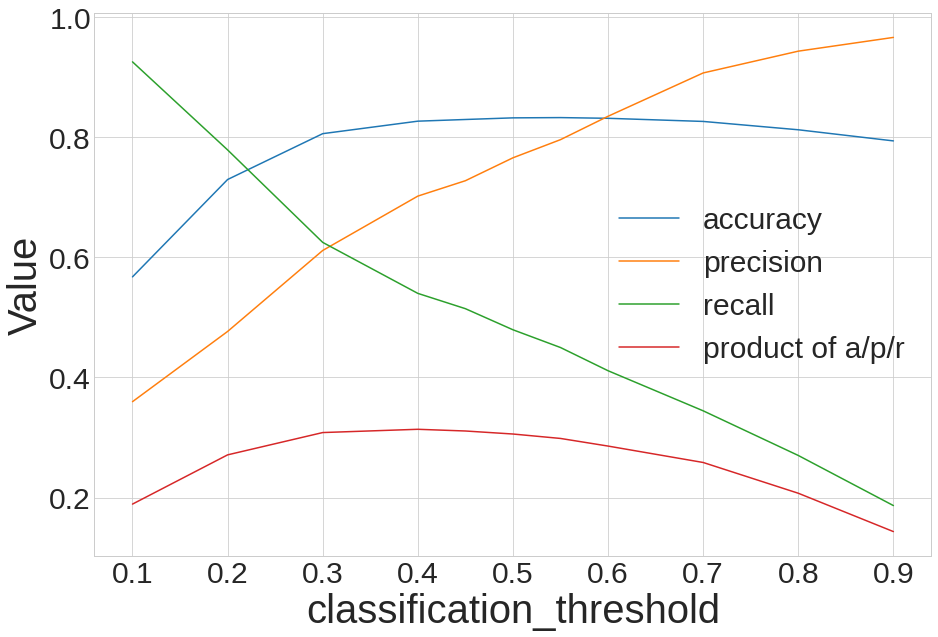

In [56]:

# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 10
batch_size = 100
# classification_threshold = 0.52  % we are going to sweep this



ACC_list = []
PREC_list = []
RECALL_list = []
SUMMARY_list = []

classifs_to_try = [0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.8, 0.9]
# classifs_to_try = [0.45, 0.5, 0.55]

for classification_threshold in classifs_to_try:

  # --- start of model

  METRICS = [
        tf.keras.metrics.BinaryAccuracy(threshold=classification_threshold,  name='accuracy'),
        tf.keras.metrics.Precision(     thresholds=classification_threshold, name='precision'),
        tf.keras.metrics.Recall(        thresholds=classification_threshold, name='recall'),
  ]
  
  number_of_inputs= X_train.shape[1]
  print(f"Number of features is {number_of_inputs}")
  print(" ")
  model = keras.Sequential([normalizer,
                            layers.Dense(10, activation='relu', input_dim=number_of_inputs),
                            layers.Dense(10, activation='relu'),
                            layers.Dense(1, activation='sigmoid') ]) # output layer for regression


  #Compile   
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=METRICS)
  
  history = model.fit(x=X_train, 
                      y=y_train, 
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_split = 0.2)  # Calculate validation results on 20% of the training data)
  
  # --- end of model

  # Extract training history
  hist = pd.DataFrame(history.history)

  x=hist['accuracy']
  x=x[len(x)-1] #  last element is the final value
  ACC_list.append(x)  

  y=hist['precision']
  y=y[len(y)-1] #  last element is the final value
  PREC_list.append(y)

  z=hist['recall']
  z=z[len(z)-1] #  last element is the final value
  RECALL_list.append(z)
  
  a=x*y*z
  SUMMARY_list.append(a)


plt.figure()
plt.xlabel("classification_threshold")
plt.ylabel("Value")

plt.plot(classifs_to_try, ACC_list, label='accuracy')
plt.plot(classifs_to_try, PREC_list, label='precision')
plt.plot(classifs_to_try, RECALL_list, label='recall')

plt.plot(classifs_to_try, SUMMARY_list, label='product of a/p/r')

 
plt.legend()

# discuss A, P & R at https://developers.google.com/machine-learning/crash-course/classification/accuracy 
